In [34]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [35]:
data = pd.read_csv("../data/100portfolioReturns.csv", index_col=0)

In [36]:
port65 = data["65"]
port65.head()

2012-04-02 00:00:00    0.000000
2012-04-03 00:00:00   -0.004758
2012-04-04 00:00:00   -0.014394
2012-04-05 00:00:00   -0.015044
2012-04-09 00:00:00   -0.027466
Name: 65, dtype: float64

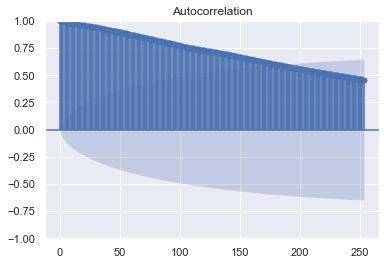

In [37]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(port65, alpha=0.05, lags=253)
plt.show()

Because the autocorrelation is significant for many lags, the past data should be a good indicator for future returns. 

In [38]:
from statsmodels.tsa.stattools import adfuller

adfuller_res = adfuller(port65)

print(f"p-value: {adfuller_res[1]}")

p-value: 0.994600981026199


Because the p-value is greater than 0.05, we fail to reject the null hypothesis that the returns are stationary. The data appears to be non-stationary with varying mean and variance over time. 

## Stationarity

To make good predictions on the data, the data needs to have stationarity. There will likely need to be some tranformations done to the data to do this. 

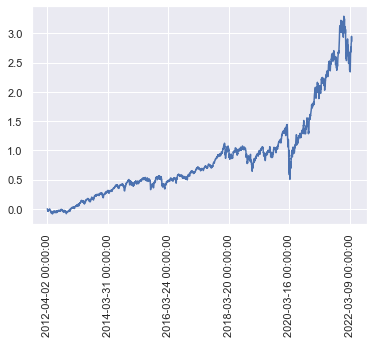

In [39]:
port65.plot()
plt.xticks(rotation=90)

plt.show()

It appears that the data is a random walk, but grows exponentially. To remove this exponential growth I will try to take the sqrt and first difference of the data.

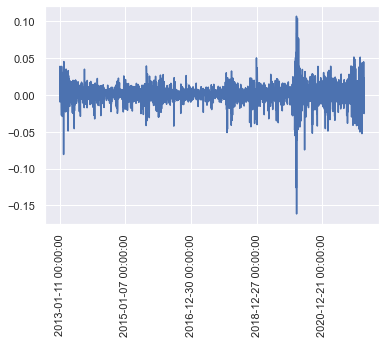

In [40]:
transformed_port = port65.apply(lambda x: np.sqrt(x)).diff()  # port65.apply(lambda x: np.log(x)).diff() | port65.apply(lambda x: np.sqrt(x)).diff() | np.log(port65/port65.shift(1))
transformed_port = transformed_port.replace([np.inf, -np.inf], np.nan)
transformed_port = transformed_port.dropna()
transformed_port.plot()
plt.xticks(rotation=90)

plt.show()

In [41]:
res = adfuller(transformed_port)

print(f"p-value: {res}")

p-value: (-13.800812588291198, 8.578479871429229e-26, 12, 2308, {'1%': -3.4331864765491247, '5%': -2.862793094456392, '10%': -2.5674370784536644}, -12976.644098351335)


This appears to make the data stationary, as I can now reject the Dickey-Fuller test with a p-value of ~0.


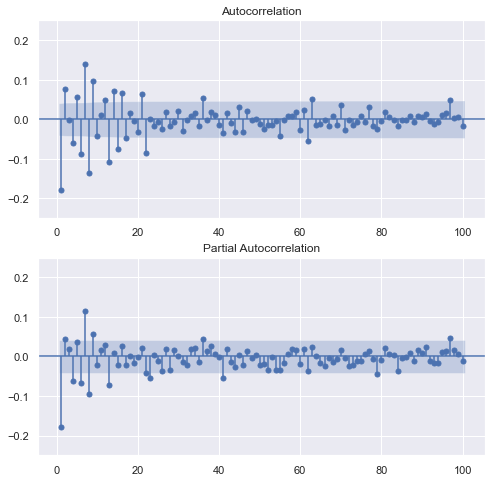

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lags = 100
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

plot_acf(transformed_port, lags=lags, zero=False, ax=ax1, )

plot_pacf(transformed_port, lags=lags, zero=False, ax=ax2)
ax1.set_ylim((-0.25, 0.25))
ax2.set_ylim((-0.25, 0.25))
plt.show()

Now that I have made the data stationary, I will look for the seasonality of the data. To do this, I will first take the original data and take the difference of the rolling mean. 

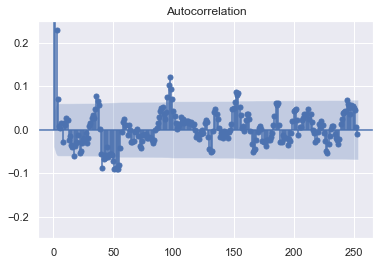

In [43]:
seasonal = port65 - port65.rolling(6).mean()
seasonal = seasonal.dropna()
plot_acf(seasonal, lags=253, zero=False)
plt.ylim((-0.25, 0.25))
plt.show()

From this it looks like the seasonality is around 45 time periods out. 


In [44]:
def splitting_tr_te(df, size=0.95):
    
    split_point = int(df.shape[0]*size)

    train = df.iloc[:split_point]
    test = df.iloc[split_point:]
    return train, test

train, test = splitting_tr_te(transformed_port)

In [45]:
import pmdarima as pm

In [46]:
results = pm.auto_arima(train, information_criterion="aic")

In [47]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2204
Model:               SARIMAX(5, 0, 4)   Log Likelihood                6353.839
Date:                Thu, 09 Jun 2022   AIC                         -12685.679
Time:                        14:42:59   BIC                         -12623.000
Sample:                             0   HQIC                        -12662.778
                               - 2204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0029      0.001      2.036      0.042       0.000       0.006
ar.L1         -1.3106      0.142     -9.203      0.000      -1.590      -1.031
ar.L2         -0.6967      0.256     -2.720      0.0

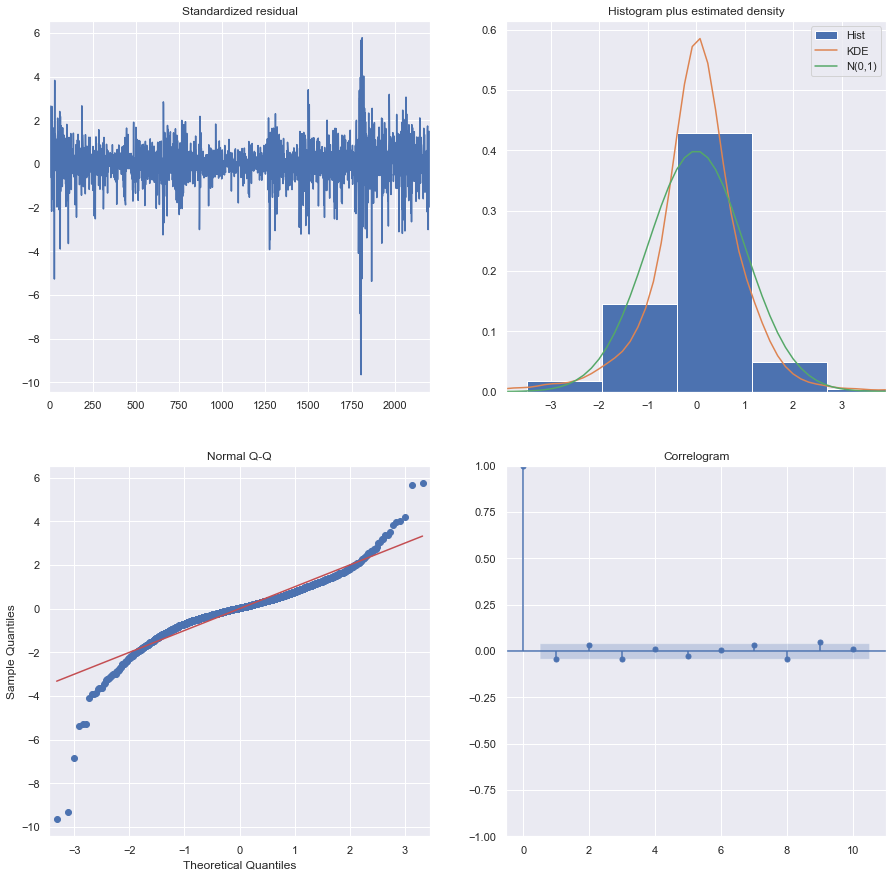

In [48]:
results.plot_diagnostics(figsize=(15, 15))
plt.show()

In [49]:
model = results

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

print(mean_squared_error(test, forecast))
print(mean_absolute_error(test, forecast))

0.0006001185459950696
0.019879019402709187


In [51]:
ci = pd.DataFrame(conf_int, columns=["lower", "upper"], index=test.index)
lower = ci["lower"]
upper = ci["upper"]

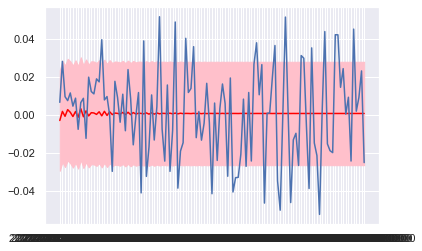

In [52]:
plt.figure()

dates = test.index

plt.plot(dates, forecast, color='red', label='forecast')
plt.plot(dates, test)

plt.fill_between(dates, lower, upper, color='pink')
plt.show()


In [53]:
pd.Series(forecast).describe()

count    117.000000
mean       0.000619
std        0.000664
min       -0.003047
25%        0.000607
50%        0.000642
75%        0.000686
max        0.003186
dtype: float64

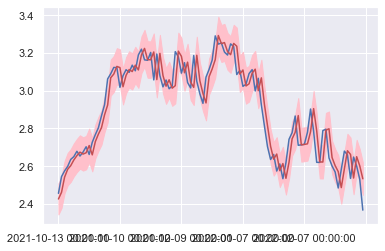

In [54]:

reverse = port65.apply(lambda x: np.sqrt(x)).shift(+1)

transformed_forecast = (forecast + reverse[test.index]) ** 2

transformed_lower = (lower + reverse[test.index]) ** 2
transformed_upper = (upper + reverse[test.index]) ** 2

port65[test.index[:100]].plot(color="b")
transformed_forecast[:100].plot(color="r")
plt.fill_between(dates[:100], transformed_lower[:100], transformed_upper[:100], color='pink')


plt.show()


In [55]:
df_tr, df_te = splitting_tr_te(port65)

In [56]:
model.fit(df_tr)

ARIMA(order=(5, 0, 4), scoring_args={}, suppress_warnings=True)

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

mod = SARIMAX(df_tr, order=(5,0,4))
res = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73771D+02    |proj g|=  6.37754D+04


 This problem is unconstrained.



At iterate    5    f=  6.86628D-01    |proj g|=  1.25544D+00
  ys=-7.716E+00  -gs= 9.600E-01 BFGS update SKIPPED

At iterate   10    f= -2.13093D+00    |proj g|=  2.44815D+00

At iterate   15    f= -2.28506D+00    |proj g|=  3.49577D-01

At iterate   20    f= -2.29128D+00    |proj g|=  3.11396D-01

At iterate   25    f= -2.29202D+00    |proj g|=  6.94936D-01

At iterate   30    f= -2.29327D+00    |proj g|=  2.03367D-02

At iterate   35    f= -2.29516D+00    |proj g|=  1.85136D-02

At iterate   40    f= -2.29564D+00    |proj g|=  3.26011D-01

At iterate   45    f= -2.29750D+00    |proj g|=  2.08506D-01

At iterate   50    f= -2.29783D+00    |proj g|=  3.35549D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

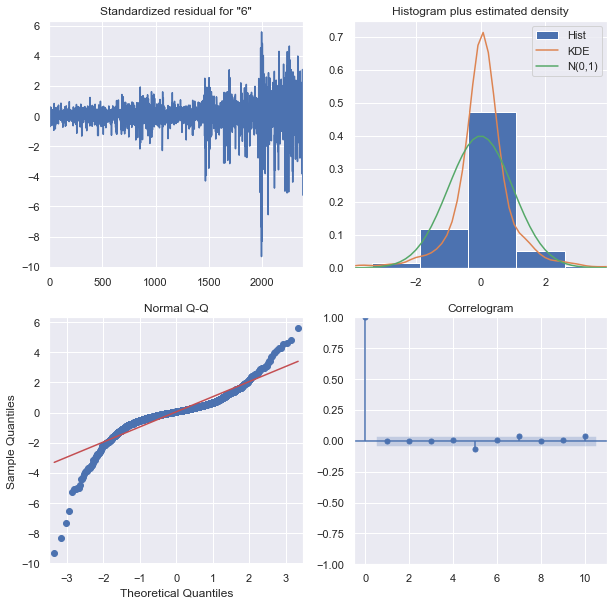

In [58]:
res.plot_diagnostics(figsize=(10, 10))
plt.show()

In [59]:
preds = res.forecast(steps=126)
print(preds)
print(mean_squared_error(df_te, preds))
print(mean_absolute_error(df_te, preds))

2390    2.428955
2391    2.420207
2392    2.433020
2393    2.419506
2394    2.431115
          ...   
2511    2.414442
2512    2.414360
2513    2.414244
2514    2.414155
2515    2.414062
Name: predicted_mean, Length: 126, dtype: float64
0.23700846093961656
0.4135194892470441


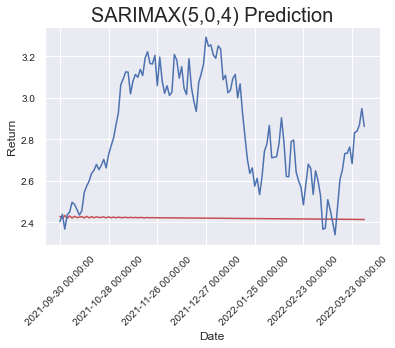

In [67]:
preds.index = df_te.index
preds.plot(color="r", label="Prediction")
df_te.plot(label="Actual")

plt.title("SARIMAX(5,0,4) Prediction", fontsize=20)

plt.xlabel("Date")
plt.ylabel("Return")
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.show()

In [64]:
import pickle

with open("../saved_models/sarimax5_0_4.pkl", "wb") as f:
    pickle.dump(mod, f)